In [18]:
import sympy as smp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Math

# REMOVE THIS IF STRANGE RESULTS OCCUR
import warnings
warnings.filterwarnings(action='ignore')

In [19]:
#@title Cubic Trajectory

def cubic_polynomial(theta, ti):
    n_eq = len(theta) - 1

    b = smp.zeros(4 * n_eq, 1)
    a = smp.zeros(4 * n_eq, 4 * n_eq)

    # Zero initial velocity condition
    a[0, 1] = 1
    b[0] = 0

    # Zero final velocity condition
    a[-1, 4 * (n_eq - 1) + 1] = 1
    a[-1, 4 * (n_eq - 1) + 2] = 2 * ti[-1]
    a[-1, 4 * (n_eq - 1) + 3] = 3 * ti[-1]**2
    b[-1] = 0

    for i in range(n_eq):
        # First positional condition
        a[4 * i + 1, 4 * i] = 1
        b[4 * i + 1] = theta[i]

        # Second positional condition
        a[4 * i + 2, 4 * i] = 1
        a[4 * i + 2, 4 * i + 1] = ti[i]
        a[4 * i + 2, 4 * i + 2] = ti[i]**2
        a[4 * i + 2, 4 * i + 3] = ti[i]**3
        b[4 * i + 2] = theta[i + 1]

    for i in range(n_eq-1):
        # Acceleration condition
        a[4 * i + 3, 4 * i + 2] = 2
        a[4 * i + 3, 4 * i + 3] = 6 * ti[i]
        a[4 * i + 3, 4 * (i+1) + 2] = -2

        # Intermediate velocity condition
        a[4 * i + 4, 4 * i + 1] = 1
        a[4 * i + 4, 4 * i + 2] = 2 * ti[i+1]
        a[4 * i + 4, 4 * i + 3] = 3 * ti[i+1]**2
        a[4 * i + 4, 4 * (i+1) + 1] = -1

    coefficients = a.solve(b)

    return coefficients

In [20]:
#@title Setup

# ti must be len(theta) - 1

theta = smp.Matrix([0, 1])
ti = smp.Matrix([2])

In [21]:
#@title Display Polynomials
coeffs = cubic_polynomial(theta, ti)

n_eqs = int(len(coeffs) / 4)

for i in range(n_eqs):
  print("Equation {}:".format(i+1))
  display(Math("\\theta(t)=" + smp.latex(coeffs[i]) + "+" + smp.latex(coeffs[i+1]) + "t+" +
               smp.latex(coeffs[i+2]) + "t^2+" + smp.latex(coeffs[i+3]) + "t^3" + "$"))

Equation 1:


<IPython.core.display.Math object>

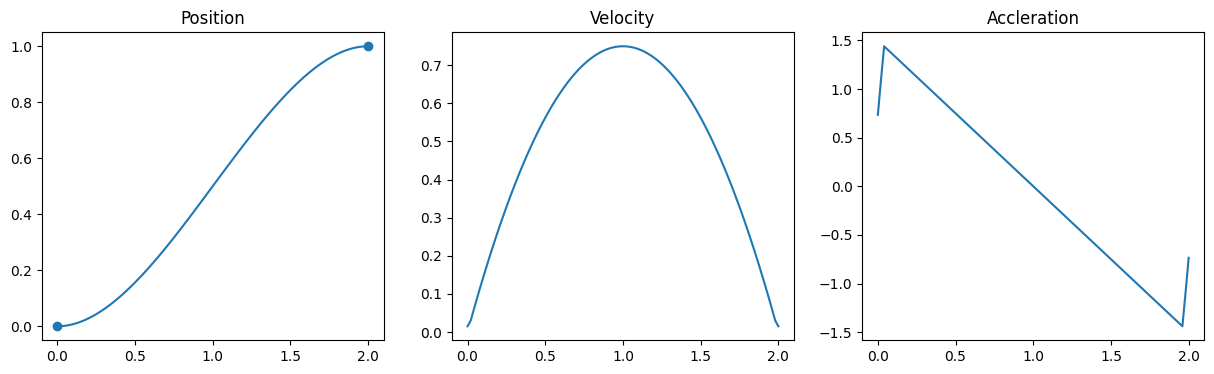

In [22]:
#@title Plot Trajectory

def plot_cubic(theta, ti, a):

    theta = np.array(theta).astype(np.float64)
    ti = np.array(ti).astype(np.float64)
    a = np.array(a).astype(np.float64)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

    t_cum = np.cumsum(ti)
    t_cum = np.insert(t_cum, 0, 0)

    xc, yc = np.zeros(1), np.zeros(1)

    for i in range(len(theta) - 1):
        t = np.linspace(t_cum[i], t_cum[i+1], 100)
        y = a[4 * i] + a[4 * i + 1] * (t-t_cum[i]) + a[4 * i + 2] * (t - t_cum[i])**2 + a[4 * i + 3] * (t - t_cum[i])**3

        xc = np.append(xc, t)
        yc = np.append(yc, y)

    xc = np.delete(xc, 0)
    yc = np.delete(yc, 0)

    vel = np.gradient(yc, xc)
    acc = np.gradient(vel, xc)

    ax[0].scatter(t_cum, theta)
    ax[0].plot(xc, yc)
    ax[0].set_title("Position")
    ax[1].plot(xc, vel)
    ax[1].set_title("Velocity")
    ax[2].plot(xc, acc)
    ax[2].set_title("Accleration")

plot_cubic(theta, ti, coeffs)

In [23]:
#@title LSPB Setup

inputs = np.array([[0],
                   [60]])

accelerations = np.array([[9.6, 9.6]])

times = np.array([5])

Vel:	 [14.0588745]
T_b:	 [1.46446609 1.46446609]


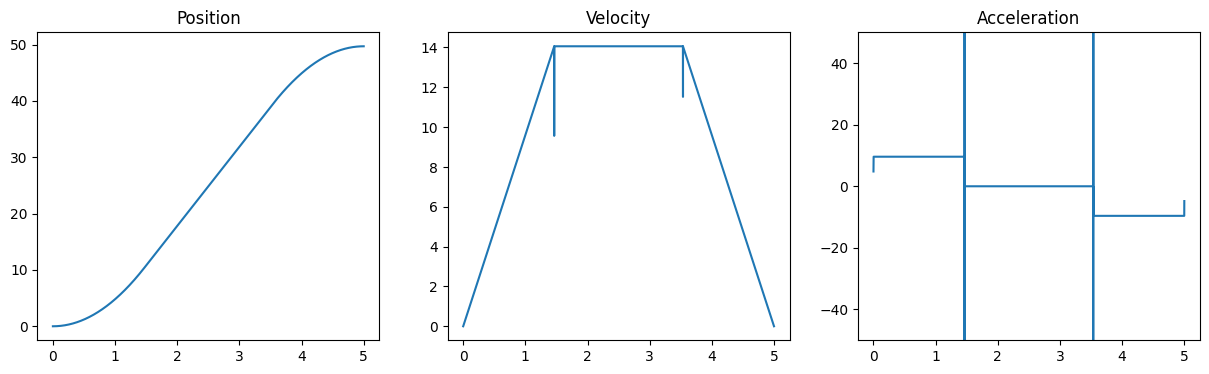

In [24]:
#@title LSPB

def blended_parabolic_motion(pos, accel, t_d, n):

    def sign(num):
        if num == 0:
            return 1
        else:
            return num / abs(num)

    n_points = len(pos)
    n_joints = len(pos[0])

    inputs = np.zeros([(n_points - 1)*n, n_joints])

    for joint in range(n_joints):

        time_array = []

        # Specified
        theta = pos[:, joint]  # Points
        # Specified
        acc = accel[joint]

        # Not specified
        t_b = np.zeros(n_points)  # Blend time at each point
        t_l = np.zeros(n_points - 1)  # Total time between points
        vel = np.zeros(n_points - 1)  # Constant velocity between points
        theta_dot = np.zeros(n_points)  # Velocities at each point

        # First segment
        acc[0] = sign(theta[1] - theta[0]) * abs(acc[0])
        t_b[0] = t_d[0] - np.sqrt(t_d[0] ** 2 - 2 * (theta[1] - theta[0]) / acc[0])
        vel[0] = (theta[1] - theta[0]) / (t_d[0] - 0.5 * t_b[0])

        # Last segment
        acc[-1] = sign(theta[-2] - theta[-1]) * abs(acc[-1])  # Notes say theta[-2] - theta[-1]
        t_b[-1] = t_d[-1] - np.sqrt(t_d[-1] ** 2 - 2 * (theta[-2] - theta[-1]) / acc[-1])
        vel[-1] = (theta[-1] - theta[-2]) / (t_d[-1] - 0.5 * t_b[-1])

        # Via points
        for i in range(1, n_points - 2):
            vel[i] = (theta[i + 1] - theta[i]) / t_d[i]
        for i in range(0, n_points - 2):
            acc[i+1] = sign(vel[i + 1] - vel[i]) * abs(acc[i+1])
        for i in range(0, n_points - 2):
            t_b[i+1] = 0.5 * (vel[i + 1] - vel[i]) / acc[i+1]
        for i in range(1, n_points - 2):
            t_l[i] = t_d[i] - 0.5 * t_b[i] - 0.5 * t_b[i+1]

        # t_l for 1st and last points
        t_l[0] = t_d[0] - t_b[0] - 0.5 * t_b[1]
        t_l[-1] = t_d[-1] - t_b[-1] - 0.5 * t_b[-2]

        # print("Points:\t", theta)
        # print("Acc:\t", acc)
        # print("T_d:\t", t_d)
        # print()
        print("Vel:\t", vel)
        print("T_b:\t", t_b)
        # print("T_l:\t", t_l)

        interp = np.array([theta[0]], dtype='float64')
        theta_0 = theta[0]
        theta_1, theta_2 = 0, 0

        for i in range(0, n_points - 1):
            theta_dot[i+1] = t_b[i+1] * acc[i+1] + vel[i]

            time = np.linspace(0, t_d[i], n)

            for t in time:
                if t < t_b[i]:
                    interp = np.append(interp, theta_0 + acc[i] * t**2 / 2 + theta_dot[i]*t)
                    theta_1 = interp[-1]
                if t_b[i] < t <= t_d[i] - t_b[i+1]:
                    interp = np.append(interp, theta_1 + (t - t_b[i])*vel[i])
                    theta_2 = interp[-1]
                if t_d[i] - t_b[i+1] < t <= t_d[i]:
                    interp = np.append(interp, theta_2 + acc[i+1]*(t + t_b[i+1] - t_d[i])**2/2 + vel[i] *
                                       (t + t_b[i+1] - t_d[i]))
                    theta_0 = interp[-1]

            time_array += list(time + np.sum(t_d[:i]))
        inputs[:, joint] = interp[1:]

    time_array = np.array(time_array)
    return time_array, inputs

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

t, pos = blended_parabolic_motion(inputs, accelerations, times, n=10000)

vel = np.gradient(pos[:, 0], t)
acc = np.gradient(vel, t)

ax[0].set_title("Position")
ax[1].set_title("Velocity")
ax[2].set_title("Acceleration")

ax[0].plot(t, pos)
ax[1].plot(t, vel)
ax[2].plot(t, acc)
ax[2].set_ylim([-50, 50])

plt.show()